In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

import pandas as pd
pd.options.display.max_columns = 100

from matplotlib import pyplot as plt
import numpy as np

import seaborn as sns
sns.set(rc={'figure.figsize':(12,9)})
import pylab as plot
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss,accuracy_score
import pickle
import time

In [2]:
from xgboost import XGBClassifier
import xgboost as xgb

In [3]:
#for scaling
from sklearn.preprocessing import StandardScaler

Importing training dataset

In [4]:
data = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


In [5]:
print(data.shape)

(867873, 10)


In [6]:
data.columns

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y', 'Id'],
      dtype='object')


Splitting the "Dates" into date and time

In [61]:
df=data
datetime=df.Dates.str.split(pat=" ",expand=True)
datetime.columns=['Date','Time']
#datetime

#------------test data-------------

df_test=test
datetime_test=df_test.Dates.str.split(pat=" ",expand=True)
datetime_test.columns=['Date','Time']

In [62]:
Date=datetime.Date.str.split(pat="-",expand=True)
Date.columns=['Year','Month','Day']

Time=datetime.Time.str.split(pat=":",expand=True)
Time.columns=['Hour','Minute','Second']

#------------test data-------------

Date_test=datetime_test.Date.str.split(pat="-",expand=True)
Date_test.columns=['Year','Month','Day']

Time_test=datetime_test.Time.str.split(pat=":",expand=True)
Time_test.columns=['Hour','Minute','Second']

Dropping the column of "Dates" and appending the dataframe "datetime"

In [63]:
df=pd.concat([df,Date,Time],axis=1)
#df

#-----------test data------------------

df_test=pd.concat([df_test,Date_test,Time_test],axis=1)


In [64]:
df=df.drop(labels=['Dates'],axis=1)

#-----------test data------------------

df_test=df_test.drop(labels=['Dates'],axis=1)


# #Encoding

In [65]:
df.columns

Index(['Category', 'Descript', 'DayOfWeek', 'PdDistrict', 'Resolution',
       'Address', 'X', 'Y', 'Id', 'Year', 'Month', 'Day', 'Hour', 'Minute',
       'Second'],
      dtype='object')

LabelEncoding of "DayOfWeek" and "PdDistrict"

In [66]:
le = preprocessing.LabelEncoder()

In [67]:
#y=pd.get_dummies(df.Category,columns=['Category'],prefix=" ",prefix_sep=" ",drop_first=True,)

le_res=le.fit_transform(df['Category'])
y=pd.DataFrame(le_res)
y.columns=['Category']
#y

In [68]:
y['Category'].nunique()

36

# Rotation 60 degree

In [69]:
df["rot60_X"]=(0.5) * df["Y"] + (1.732/2) * df["X"]
df["rot60_Y"]=0.5 * df["Y"] - (1.732/2) * df["X"]



df_test["rot60_X"]=(0.5) * df_test["Y"] + (1.732/2) * df_test["X"]
df_test["rot60_Y"]=0.5 * df_test["Y"] - (1.732/2) * df_test["X"]

In [70]:
df["radial60"]=np.sqrt(np.power(df['rot60_X'],2) + np.power(df['rot60_Y'],2))

df_test["radial60"]=np.sqrt(np.power(df_test['rot60_X'],2) + np.power(df_test['rot60_Y'],2))

# Month clubbing

In [71]:
df=df.drop(labels='rot60_X',axis=1)

df_test=df_test.drop(labels='rot60_X',axis=1)

In [72]:
df=df.drop(labels='rot60_Y',axis=1)

df_test=df_test.drop(labels='rot60_Y',axis=1)

In [73]:
df=df.drop(labels='Second',axis=1)

df_test=df_test.drop(labels='Second',axis=1)

# Minute Clubbing

In [74]:
df['Minute']=df['Minute'].apply(lambda x:int(x))
df['Minute']=df['Minute'].apply(lambda x : 'low' if x <31 else 'high')

df_test['Minute']=df_test['Minute'].apply(lambda x:int(x))
df_test['Minute']=df_test['Minute'].apply(lambda x : 'low' if x <31 else 'high')


# DayOfWeek

In [75]:
df['DayOfWeek']= df['DayOfWeek'].apply(lambda x : 'WeekHigh' if x in ('Wednesday','Friday') else ('WeekMed' if x in ('Tuesday','Thursday','Saturday') else 'WeekLow'))


df_test['DayOfWeek']= df_test['DayOfWeek'].apply(lambda x : 'WeekHigh' if x in ('Wednesday','Friday') else ('WeekMed' if x in ('Tuesday','Thursday','Saturday') else 'WeekLow'))


# Address Update

In [76]:
df['Intersection']=df['Address'].apply(lambda x : 1 if '/' in x else 0)
df['Block']=df['Address'].apply(lambda x : 1 if 'Block' in x else 0)
df_test['Intersection']=df_test['Address'].apply(lambda x : 1 if '/' in x else 0)
df_test['Block']=df_test['Address'].apply(lambda x : 1 if 'Block' in x else 0)

In [77]:
address=pd.DataFrame(df['Address'],columns=['Address'])
address=address.Address.str.split(pat=" /",expand=True )

address.columns=['Address','Intr2']

address=address.Address.str.split(pat=" /",expand=True )
address.columns=['Address']

string=address.iloc[:,0]
string=string.str.strip()

address_fram=string.to_frame()
temp=address_fram['Address'].astype(str).str[-2:]

address=temp.to_frame()

address['Address']=address['Address'].apply(lambda x :( x if x in ("ST","AV","LN","DR","BL","HY","CT","RD","PL","PZ","TR","AL","CR","WK","EX","RW") else (("I-80" if x in ("80") else ("HWY" if x in ("WY") else ("WAY" if x in ("AY") else ("TER" if x in ("ER") else ("ALMS" if x in ("MS") else ("MAR" if x in ("AR") else ("PARK" if x in ("RK") else ("STWY" if x in ("WY") else ("VIA" if x in ("NO") else ("BLOCK")))))))))))))
df=df.drop(labels=['Address'],axis=1)
df=pd.concat([address,df],axis=1)



# Address splitting

In [78]:
address_test=pd.DataFrame(df_test['Address'],columns=['Address'])
address_test=address_test.Address.str.split(pat=" /",expand=True )

address_test.columns=['Address','Intr2']

address_test=address_test.Address.str.split(pat=" /",expand=True )
address_test.columns=['Address']

string_test=address_test.iloc[:,0]
string_test=string_test.str.strip()

address_fram_test=string_test.to_frame()
temp_test=address_fram_test['Address'].astype(str).str[-2:]

address_test=temp_test.to_frame()

address_test['Address']=address_test['Address'].apply(lambda x :( x if x in ("ST","AV","LN","DR","BL","HY","CT","RD","PL","PZ","TR","AL","CR","WK","EX","RW") else (("I-80" if x in ("80") else ("HWY" if x in ("WY") else ("WAY" if x in ("AY") else ("TER" if x in ("ER") else ("ALMS" if x in ("MS") else ("MAR" if x in ("AR") else ("PARK" if x in ("RK") else ("STWY" if x in ("WY") else ("VIA" if x in ("NO") else ("BLOCK")))))))))))))
df_test=df_test.drop(labels=['Address'],axis=1)
df_test=pd.concat([address_test,df_test],axis=1)

In [79]:
Id=df['Id']
df=df.drop(['Descript','Resolution','Id'],axis=1)

#----------test data---------

Id_test=df_test['Id']
df_test=df_test.drop(['Descript','Resolution','Id'],axis=1)

In [80]:
df_test.columns

Index(['Address', 'DayOfWeek', 'PdDistrict', 'X', 'Y', 'Year', 'Month', 'Day',
       'Hour', 'Minute', 'radial60', 'Intersection', 'Block'],
      dtype='object')

In [81]:
data['PdDistrict'].unique()

array(['MISSION', 'SOUTHERN', 'BAYVIEW', 'CENTRAL', 'INGLESIDE',
       'NORTHERN', 'RICHMOND', 'TARAVAL', 'TENDERLOIN', 'PARK'],
      dtype=object)

# Label Encoding

In [82]:

df.columns

Index(['Address', 'Category', 'DayOfWeek', 'PdDistrict', 'X', 'Y', 'Year',
       'Month', 'Day', 'Hour', 'Minute', 'radial60', 'Intersection', 'Block'],
      dtype='object')

In [83]:
df_test.columns

Index(['Address', 'DayOfWeek', 'PdDistrict', 'X', 'Y', 'Year', 'Month', 'Day',
       'Hour', 'Minute', 'radial60', 'Intersection', 'Block'],
      dtype='object')

In [84]:
le = preprocessing.LabelEncoder()

Label Encoding :DayOfWeek

In [85]:

#le = preprocessing.LabelEncoder()
le_res=le.fit_transform(df['DayOfWeek'])
Day=pd.DataFrame(le_res)
Day.columns=['DayOfWeek']
df=df.drop(labels=['DayOfWeek'],axis=1)
df=pd.concat([Day,df],axis=1)

#----------test data----------

le_res_test=le.fit_transform(df_test['DayOfWeek'])
Day_test=pd.DataFrame(le_res_test)
Day_test.columns=['DayOfWeek']
df_test=df_test.drop(labels=['DayOfWeek'],axis=1)
df_test=pd.concat([Day_test,df_test],axis=1)

Label Encoding: PdDistrict

In [86]:

le_res=le.fit_transform(df['PdDistrict'])
District=pd.DataFrame(le_res)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
District.columns=['District']
df=df.drop(labels=['PdDistrict'],axis=1)
df=pd.concat([District,df],axis=1)


le_res_test=le.fit_transform(df_test['PdDistrict'])
District_test=pd.DataFrame(le_res_test)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
District_test.columns=['District']
df_test=df_test.drop(labels=['PdDistrict'],axis=1)
df_test=pd.concat([District_test,df_test],axis=1)


Label encoding: Year

In [87]:

#le = preprocessing.LabelEncoder()
le_res=le.fit_transform(df['Year'])
Year=pd.DataFrame(le_res)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Year.columns=['Year']
df=df.drop(labels=['Year'],axis=1)
df=pd.concat([Year,df],axis=1)


#le = preprocessing.LabelEncoder()
le_res_test=le.fit_transform(df_test['Year'])
Year_test=pd.DataFrame(le_res_test)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Year_test.columns=['Year']
df_test=df_test.drop(labels=['Year'],axis=1)
df_test=pd.concat([Year_test,df_test],axis=1)


Label encoding: Month

In [88]:

#le = preprocessing.LabelEncoder()
le_res=le.fit_transform(df['Month'])
Month=pd.DataFrame(le_res)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Month.columns=['Month']
df=df.drop(labels=['Month'],axis=1)
df=pd.concat([Month,df],axis=1)


#le = preprocessing.LabelEncoder()
le_res_test=le.fit_transform(df_test['Month'])
Month_test=pd.DataFrame(le_res_test)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Month_test.columns=['Month']
df_test=df_test.drop(labels=['Month'],axis=1)
df_test=pd.concat([Month_test,df_test],axis=1)


Label encoding: Day

In [89]:

#le = preprocessing.LabelEncoder()
le_res=le.fit_transform(df['Day'])
Day=pd.DataFrame(le_res)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Day.columns=['Day']
df=df.drop(labels=['Day'],axis=1)
df=pd.concat([Day,df],axis=1)


#le = preprocessing.LabelEncoder()
le_res_test=le.fit_transform(df_test['Day'])
Day_test=pd.DataFrame(le_res_test)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Day_test.columns=['Day']
df_test=df_test.drop(labels=['Day'],axis=1)
df_test=pd.concat([Day_test,df_test],axis=1)


Label encoding: Hour

In [90]:

#le = preprocessing.LabelEncoder()
le_res=le.fit_transform(df['Hour'])
Hour=pd.DataFrame(le_res)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Hour.columns=['Hour']
df=df.drop(labels=['Hour'],axis=1)
df=pd.concat([Hour,df],axis=1)


#le = preprocessing.LabelEncoder()
le_res_test=le.fit_transform(df_test['Hour'])
Hour_test=pd.DataFrame(le_res_test)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Hour_test.columns=['Hour']
df_test=df_test.drop(labels=['Hour'],axis=1)
df_test=pd.concat([Hour_test,df_test],axis=1)


Label encoding: Minute

In [91]:

le_res=le.fit_transform(df['Minute'])
Minute=pd.DataFrame(le_res)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Minute.columns=['Minute']
df=df.drop(labels=['Minute'],axis=1)
df=pd.concat([Minute,df],axis=1)


le_res_test=le.fit_transform(df_test['Minute'])
Minute_test=pd.DataFrame(le_res_test)

#District=pd.get_dummies(df['PdDistrict'],drop_first=True)
Minute_test.columns=['Minute']
df_test=df_test.drop(labels=['Minute'],axis=1)
df_test=pd.concat([Minute_test,df_test],axis=1)



#label encode street suffix

In [92]:
le_res=le.fit_transform(df['Category'])
cat=pd.DataFrame(le_res)
cat.columns=['Category']
df=df.drop(labels=['Category'],axis=1)
df=pd.concat([cat,df],axis=1)

df.columns

Index(['Category', 'Minute', 'Hour', 'Day', 'Month', 'Year', 'District',
       'DayOfWeek', 'Address', 'X', 'Y', 'radial60', 'Intersection', 'Block'],
      dtype='object')

In [93]:

le_res=le.fit_transform(df['Address'])
Address=pd.DataFrame(le_res)
Address.columns=['Address']
df=df.drop(labels=['Address'],axis=1)
df=pd.concat([Address,df],axis=1)
le_res=le.fit_transform(df_test['Address'])
Address_test=pd.DataFrame(le_res)
Address_test.columns=['Address']
df_test=df_test.drop(labels=['Address'],axis=1)
df_test=pd.concat([Address_test,df_test],axis=1)

In [94]:
df.head()

,Address,Category,Minute,Hour,Day,Month,Year,District,DayOfWeek,X,Y,radial60,Intersection,Block
0,19,27,0,17,27,5,10,3,0,-122.419331,37.762264,152.287276,0,1
1,19,17,0,2,18,1,1,7,2,-122.411340,37.781271,152.279998,0,1
2,19,13,1,0,13,10,4,7,0,-122.403405,37.775421,152.269705,0,1
3,2,24,1,18,26,11,4,0,2,-122.404715,37.730161,152.265674,0,1
4,19,21,1,17,8,8,9,7,1,-122.405239,37.785265,152.273137,1,0


In [95]:
from sklearn.cluster import KMeans
v1=np.array(df.iloc[:,1:3])
kk=KMeans(n_clusters=36, random_state=0)
kk.fit(v1)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=36, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=0, tol=0.0001, verbose=0)

In [96]:
#'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','A1','A2','A3'','A4'','A5'','A6'','A7'','A8'','A9'','A10'
kmean= pd.DataFrame(kk.transform(v1))
kmean.columns=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','A1','A2','A3','A4','A5','A6','A7','A8','A9','A10']
df=df.drop(labels=['X','Y'],axis=1)
df=pd.concat([kmean,df],axis=1)

In [97]:
v1_test=np.array(df_test.iloc[:,1:3])
kmean_test= pd.DataFrame(kk.transform(v1_test))
kmean_test.columns=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','A1','A2','A3','A4','A5','A6','A7','A8','A9','A10']
df_test=df_test.drop(labels=['X','Y'],axis=1)
df_test=pd.concat([kmean_test,df_test],axis=1)

In [98]:
df_test.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Address,Minute,Hour,Day,Month,Year,District,DayOfWeek,radial60,Intersection,Block
0,26.624356,38.013156,22.649826,29.732137,22.000003,33.359773,25.196183,40.358290,22.202687,29.832868,29.068884,31.284070,23.496937,38.832976,36.389180,22.803509,27.464014,23.769729,30.479501,31.827661,39.661064,35.058827,23.000008,38.412006,28.404292,24.741063,32.560638,23.222845,37.202150,39.408121,40.496913,36.997583,34.161260,29.144469,30.413813,23.590477,14,1,23,3,6,7,9,1,152.276406,0,1
1,26.397855,38.275318,21.898239,29.698485,21.023232,33.468325,24.830702,40.633949,21.376289,29.732137,29.000000,31.278519,22.874571,39.115214,36.607976,22.135944,27.208275,23.086793,30.413813,31.890437,39.962482,35.219236,22.021863,38.639515,28.297302,24.324165,32.592799,22.399094,37.443290,39.661064,40.816663,37.185757,34.302697,29.003439,30.413813,23.035123,3,0,22,25,5,1,5,2,152.319061,0,1
2,24.997126,36.891733,20.692820,28.284271,20.000004,32.061183,23.457318,39.252918,20.222742,28.319605,27.586228,29.864564,21.595971,37.735925,35.216082,20.880613,25.812247,21.840330,29.000000,30.479501,38.587563,33.818158,21.000009,37.248922,26.885011,22.964916,31.180045,21.243835,36.055513,38.275318,39.446166,35.788562,32.899215,27.593478,29.000000,21.725633,14,1,21,8,1,10,7,2,152.267363,1,0
3,25.804192,37.443290,21.670342,29.000000,21.000003,32.701636,24.321733,39.796879,21.212244,29.068884,28.319605,30.566201,22.544312,38.275318,35.793469,21.840330,26.632163,22.803509,29.732137,31.144823,39.115214,34.429560,22.000008,37.821716,27.637001,23.848560,31.862128,22.232870,36.619667,38.832976,39.962482,36.384353,33.521262,28.361947,29.698485,22.655173,2,1,22,2,11,3,4,1,152.289583,1,0
4,17.459860,32.756679,9.043243,22.135944,7.069390,26.859705,14.844221,35.087288,8.058891,21.540659,21.189620,23.806293,10.918117,33.734256,30.791945,9.899495,17.896654,10.630146,22.472205,25.000000,34.713110,28.952022,8.059928,32.756864,20.217252,13.947585,25.343451,9.039878,31.780497,33.955854,35.693137,31.028704,27.932807,20.523145,23.086793,11.621738,14,0,8,20,8,11,5,1,152.326699,1,0


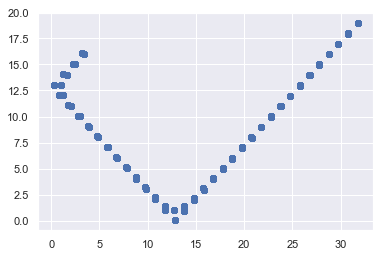

In [99]:
#points = df[]
# create scatter plot
plt.scatter(kmean['X'], kmean['Y'], cmap='viridis')
#plt.xlim(-15,15)
#plt.ylim(-15,15)

In [100]:
df=df[['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','A1','A2','A3','A4','A5','A6','A7','A8','A9','A10', 'Year','Hour','Minute','Address', 'Intersection','Block']]


df_test=df_test[['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','A1','A2','A3','A4','A5','A6','A7','A8','A9','A10', 'Year','Hour','Minute','Address', 'Intersection','Block']]
#'radial60'

In [46]:
df['Address'].nunique()

25

In [47]:
df_test['Address'].nunique()

18

In [48]:
df_test.columns

Index(['X', 'Y', 'Year', 'Hour', 'Minute', 'Address', 'Intersection', 'Block'], dtype='object')

In [49]:
A=df.corr()
A

,X,Y,Year,Hour,Minute,Address,Intersection,Block
X,1.000000,-0.424941,-0.028415,-0.015375,-0.015765,0.017870,-0.110093,0.110093
Y,-0.424941,1.000000,-0.041513,0.003724,-0.013377,-0.047896,0.013730,-0.013730
Year,-0.028415,-0.041513,1.000000,-0.006327,-0.019751,0.007029,-0.027507,0.027507
Hour,-0.015375,0.003724,-0.006327,1.000000,0.002779,0.002345,0.043905,-0.043905
Minute,-0.015765,-0.013377,-0.019751,0.002779,1.000000,-0.022238,-0.037279,0.037279
Address,0.017870,-0.047896,0.007029,0.002345,-0.022238,1.000000,0.055232,-0.055232
Intersection,-0.110093,0.013730,-0.027507,0.043905,-0.037279,0.055232,1.000000,-1.000000
Block,0.110093,-0.013730,0.027507,-0.043905,0.037279,-0.055232,-1.000000,1.000000


# Splitting into test and train


In [101]:
X=df

In [102]:
#splitting the dataset into the training set and test set
#from sklearn import model_selection as ms

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33,random_state=0)

In [103]:
X_train.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,Year,Hour,Minute,Address,Intersection,Block
91620,17.004791,1.000000,27.536178,12.000000,32.011935,7.138105,19.992037,1.533889,29.006790,13.038405,1.300000e+01,10.496815,25.003698,6.743496e-07,3.014272,26.000000,17.020335,26.019224,12.041595,9.000000,1.000000,5.013188,32.034568,1.589134,14.033258,21.045187,9.008006,28.807920,2.000000,1.000000,2.000000,3.181573,6.002089,14.135694,11.00000,23.820324,10,19,1,19,1,0
465524,4.004791,12.000000,14.536864,1.000000,19.011935,5.870746,6.993090,14.198365,16.006790,1.000000,2.384186e-07,2.621802,12.007703,1.300000e+01,9.985728,13.000000,4.114310,13.038405,1.414214,4.000000,14.000000,8.008249,19.045228,11.807374,1.033258,8.046476,4.169370,15.822191,11.000000,13.038405,15.000000,10.029645,7.001790,1.486813,2.00000,10.820729,2,23,1,19,0,1
791676,3.004791,13.000000,13.536971,2.000000,18.011935,6.870039,5.993360,15.196045,15.006790,1.414214,1.000000e+00,3.595410,11.008402,1.400000e+01,10.985728,12.000000,3.153677,12.041595,2.236068,5.000000,15.000000,9.007333,18.046684,12.804061,0.033258,7.046772,5.145774,14.824325,12.000000,14.035669,16.000000,11.025113,8.001567,1.005015,3.00000,9.820805,5,22,1,19,0,1
24679,1.417605,15.033296,11.562743,4.123106,16.043131,8.898510,4.080877,17.163106,13.045175,3.000000,3.162278e+00,5.534690,9.018030,1.603122e+01,13.024175,10.049876,0.990933,10.000000,4.000000,7.071068,17.029386,11.018406,16.018957,14.764951,2.206371,5.110089,7.047672,12.790558,14.035669,16.000000,18.027756,12.979668,10.035358,1.899722,5.09902,7.868580,2,15,0,19,1,0
129707,0.004791,16.000000,10.537415,5.000000,15.011935,9.868777,2.995252,18.190613,12.006790,4.123106,4.000000e+00,6.564021,8.011549,1.700000e+01,13.985728,9.000000,1.000041,9.055385,5.099020,8.000000,18.000000,12.005501,15.052211,15.796635,2.966742,4.048537,8.109564,11.832889,15.000000,17.029386,19.000000,14.015389,11.001139,3.067310,6.00000,6.821166,3,20,1,19,1,0


# XGBoost 

In [53]:
model = xgb.XGBClassifier(objective='multi:softprob')


# LightGBM

In [104]:
import lightgbm as lgb

model= lgb.LGBMClassifier(objective='multiclass')

In [209]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors =36,weights='distance',algorithm='ball_tree',n_jobs=-1,p=1, metric = 'minkowski',leaf_size=60)

In [210]:
from sklearn.ensemble import RandomForestClassifier
model= RandomForestClassifier(n_estimators =20,criterion = 'entropy',random_state = 0)

In [100]:
from sklearn.naive_bayes import GaussianNB
nv = GaussianNB()

# LogLoss


In [105]:
model.fit(X_train, y_train)
y_pred=model.predict_proba(df_test)
#print (log_loss(y_test,y_pred));

C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\anaconda\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [106]:
temp = data['Category']

le.fit_transform(temp)
le.classes_
y_pred= pd.DataFrame(y_pred, index=Id_test,columns  = le.classes_)
y_pred.to_csv("submit.csv", float_format = '%.5F')


In [107]:
# import statements
from sklearn.datasets import make_blobs

# create blobs
data = make_blobs(n_samples=200, n_features=2, centers=4, cluster_std=1.6, random_state=50)
# create np array for data points


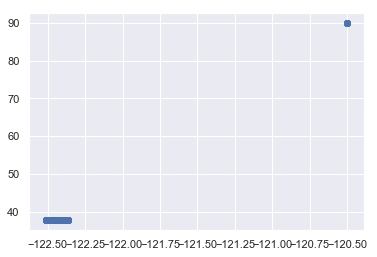

In [60]:
#points = df[]
# create scatter plot
plt.scatter(df['X'], df['Y'], cmap='viridis')
#plt.xlim(-15,15)
x#plt.ylim(-15,15)